# Import Libraries.

In [1]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from rdkit.Chem.Scaffolds.MurckoScaffold import GetScaffoldForMol
import pandas as pd

# Load file with smiles.

In [2]:
df = pd.read_csv("smiles_pKi.csv")
df.head()

,ID,pKi,Smiles
0,CHEMBL3685195,8.70,O=C(Nc1ccc(Cl)c(-c2ccc3cc(NC(=O)C4CC4)ncc3c2)c...
1,CHEMBL3685132,8.15,Cn1ccc(Oc2ccc3cc(NC(=O)C4CC4)ncc3c2)n1
2,CHEMBL3685135,7.96,O=C(Nc1cc2ccc(-c3ccc4cn[nH]c4c3)cc2cn1)C1CC1
3,CHEMBL3685092,9.10,CC(C)Oc1ccc2cc(NC(=O)C3CC3)ncc2c1
4,CHEMBL3685139,9.52,Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)cc2)cc1-c1ccc2...


# Add RDKit molecule objects to pandas dataframe.

In [3]:
PandasTools.AddMoleculeColumnToFrame(df,'Smiles')

,ID,pKi,Smiles,ROMol
0,CHEMBL3685195,8.70,O=C(Nc1ccc(Cl)c(-c2ccc3cc(NC(=O)C4CC4)ncc3c2)c...,
1,CHEMBL3685132,8.15,Cn1ccc(Oc2ccc3cc(NC(=O)C4CC4)ncc3c2)n1,
2,CHEMBL3685135,7.96,O=C(Nc1cc2ccc(-c3ccc4cn[nH]c4c3)cc2cn1)C1CC1,

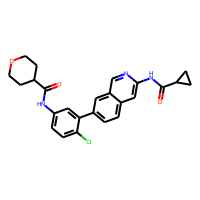
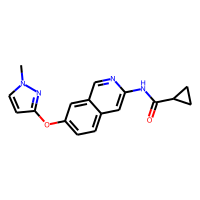
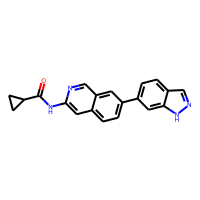

In [4]:
df.head(3)

# Extract Murcko scaffolds.

In [5]:
MurckoG = []
for each_mol in df["ROMol"]:
    try:
        MurckoG.append(Chem.MolToSmiles(GetScaffoldForMol(each_mol)))
    except:
        MurckoG.append(each_mol)
df["Murcko"] = MurckoG

In [6]:
df["Murcko"].value_counts()

O=C(Nc1cc2ccc(-c3ccccc3)cc2cn1)C1CC1                             60
O=C(Nc1cc2ccc(-c3cccnc3)cc2cn1)C1CC1                             52
c1ccc(CCn2ncc3c(NCc4ccccc4)ncnc32)cc1                            44
c1ccc(-c2ccc3ccncc3c2)cc1                                        24
c1ccc(CCn2ncc3c(Nc4ccccc4)ncnc32)cc1                             21
                                                                 ..
O=C(Nc1cccc(-c2ccc3cc(NC(=O)C4CC4)ncc3c2)c1)c1ccc(C2CCNC2)cc1     1
O=C(Nc1ccccc1)Nc1nnc(Cc2ccccc2)s1                                 1
O=C(Nc1cc2cnc(C3CCCCC3)cc2cn1)C1CC1                               1
O=C(Nc1cc2ccc(-c3ccccc3)cc2cn1)C1CCNC1                            1
O=C(Nc1cccc(-c2ccc3cc(NC(=O)C4CC4)ncc3c2)c1)C1CCOC1               1
Name: Murcko, Length: 174, dtype: int64

# Subset dataframe to scaffold of interest.

In [7]:
cur_scaf_smiles = 'O=C(Nc1cc2ccc(-c3ccccc3)cc2cn1)C1CC1'
cur_scaf_df = df[df["Murcko"]==cur_scaf_smiles]
mol_scaffold_of_interest = Chem.MolFromSmiles(cur_scaf_smiles)

# HIGHLIGHT COMMON CORE SUBSTRUCTURES IN STRUCTURES.

In [8]:
custom_legend = [' : '.join(tup) for tup in list(zip(cur_scaf_df['ID'], cur_scaf_df['pKi'].astype(str)))]

C:\Users\kzphy\miniconda3\envs\cheminformatics\lib\site-packages\rdkit\Chem\Draw\IPythonConsole.py:192: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  % (maxMols))


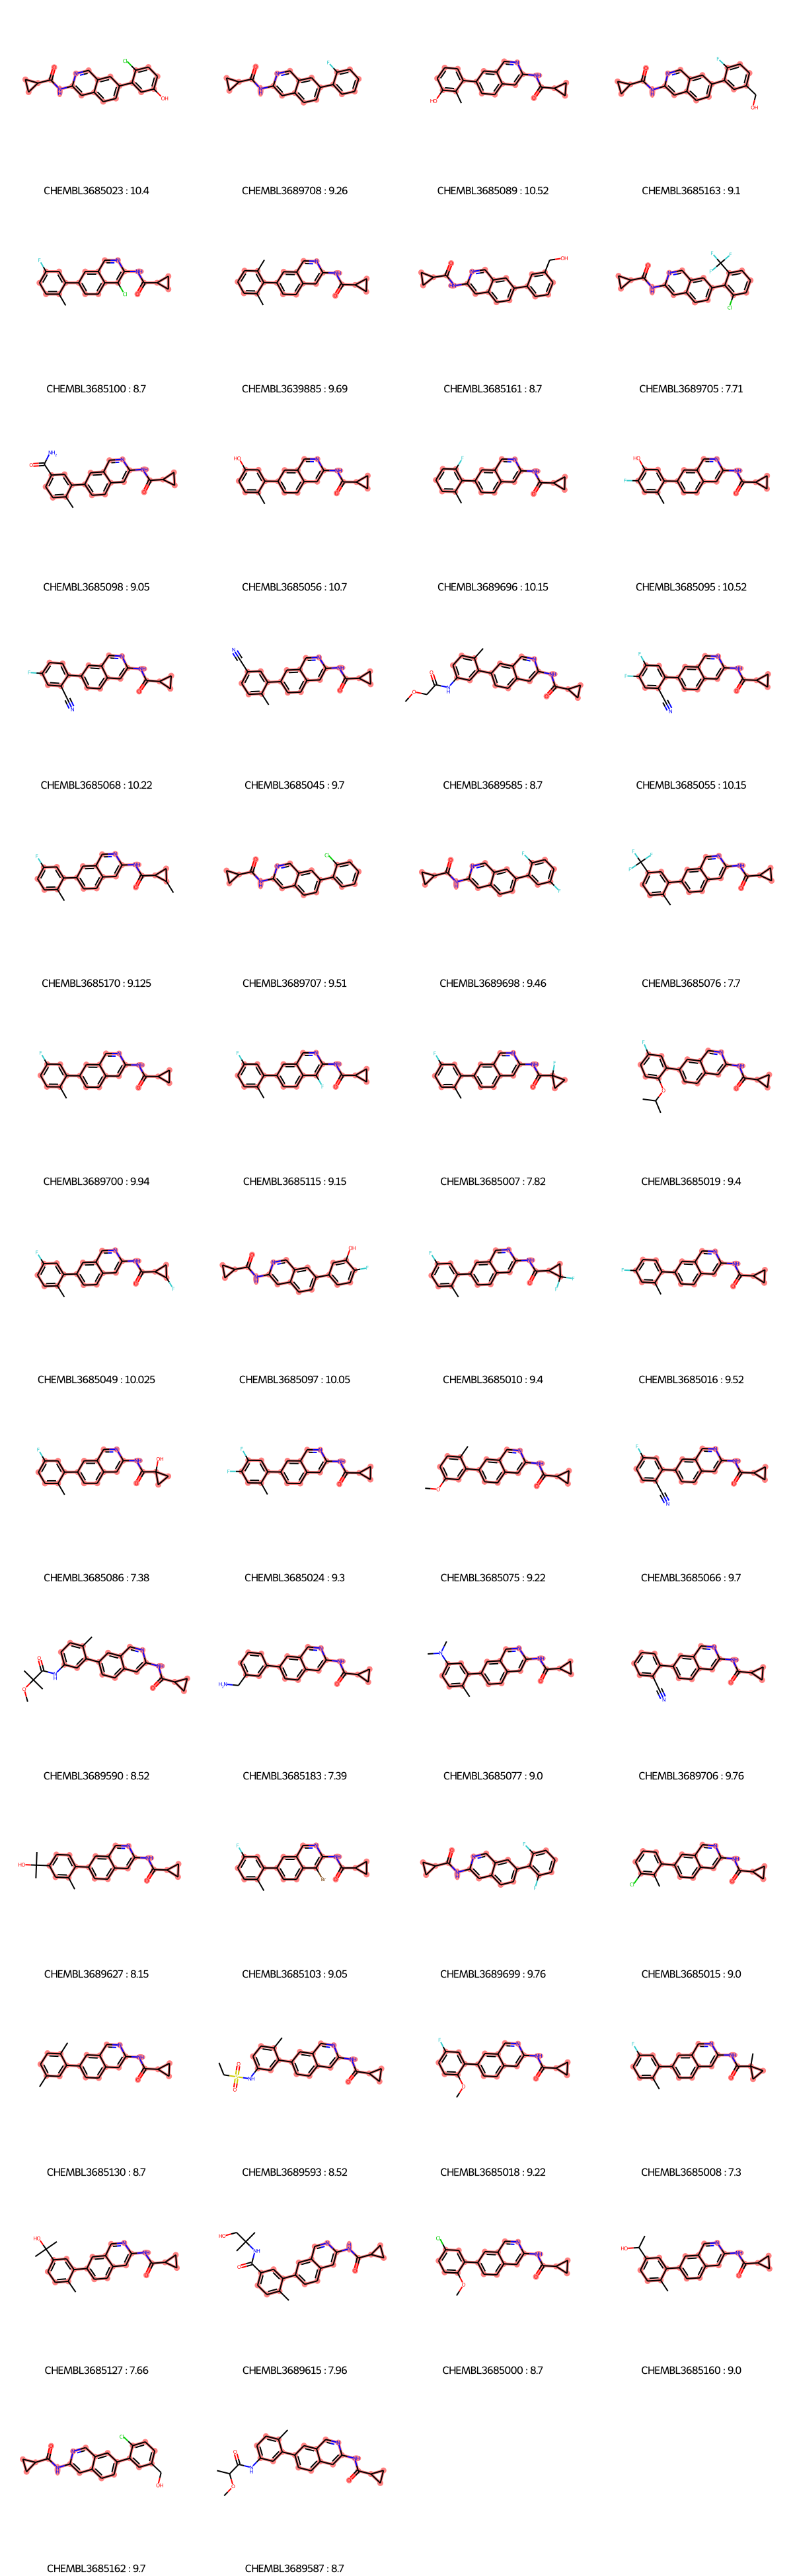

In [9]:
highlight_scaffold = [mMol.GetSubstructMatch(Chem.MolFromSmiles(cur_scaf_smiles)) for mMol in cur_scaf_df['ROMol']]
Draw.MolsToGridImage(cur_scaf_df['ROMol'], 
                     legends = custom_legend,
                     highlightAtomLists = highlight_scaffold, 
                     molsPerRow=4,
                     subImgSize=(300,300), useSVG=False)

# HIGHLIGHT DIFFERENCES IN STRUCTURES.

### Function to extract atoms to highlight differences in structures.

In [10]:
def get_atoms_to_highlight(mol_scaffold_of_interest, mol_compound_of_interest):
    atom_list = [i for i in range(mol_compound_of_interest.GetNumAtoms())]
    grouped_common_atoms = mol_compound_of_interest.GetSubstructMatches(mol_scaffold_of_interest)
    flattened_grouped_common_atoms = list(sum(grouped_common_atoms, ()))
    atoms_to_highlight = list(set(atom_list) - set(flattened_grouped_common_atoms))
    return atoms_to_highlight

### In the subset dataframe, apply the function to get atoms for highlighting differences in structures.

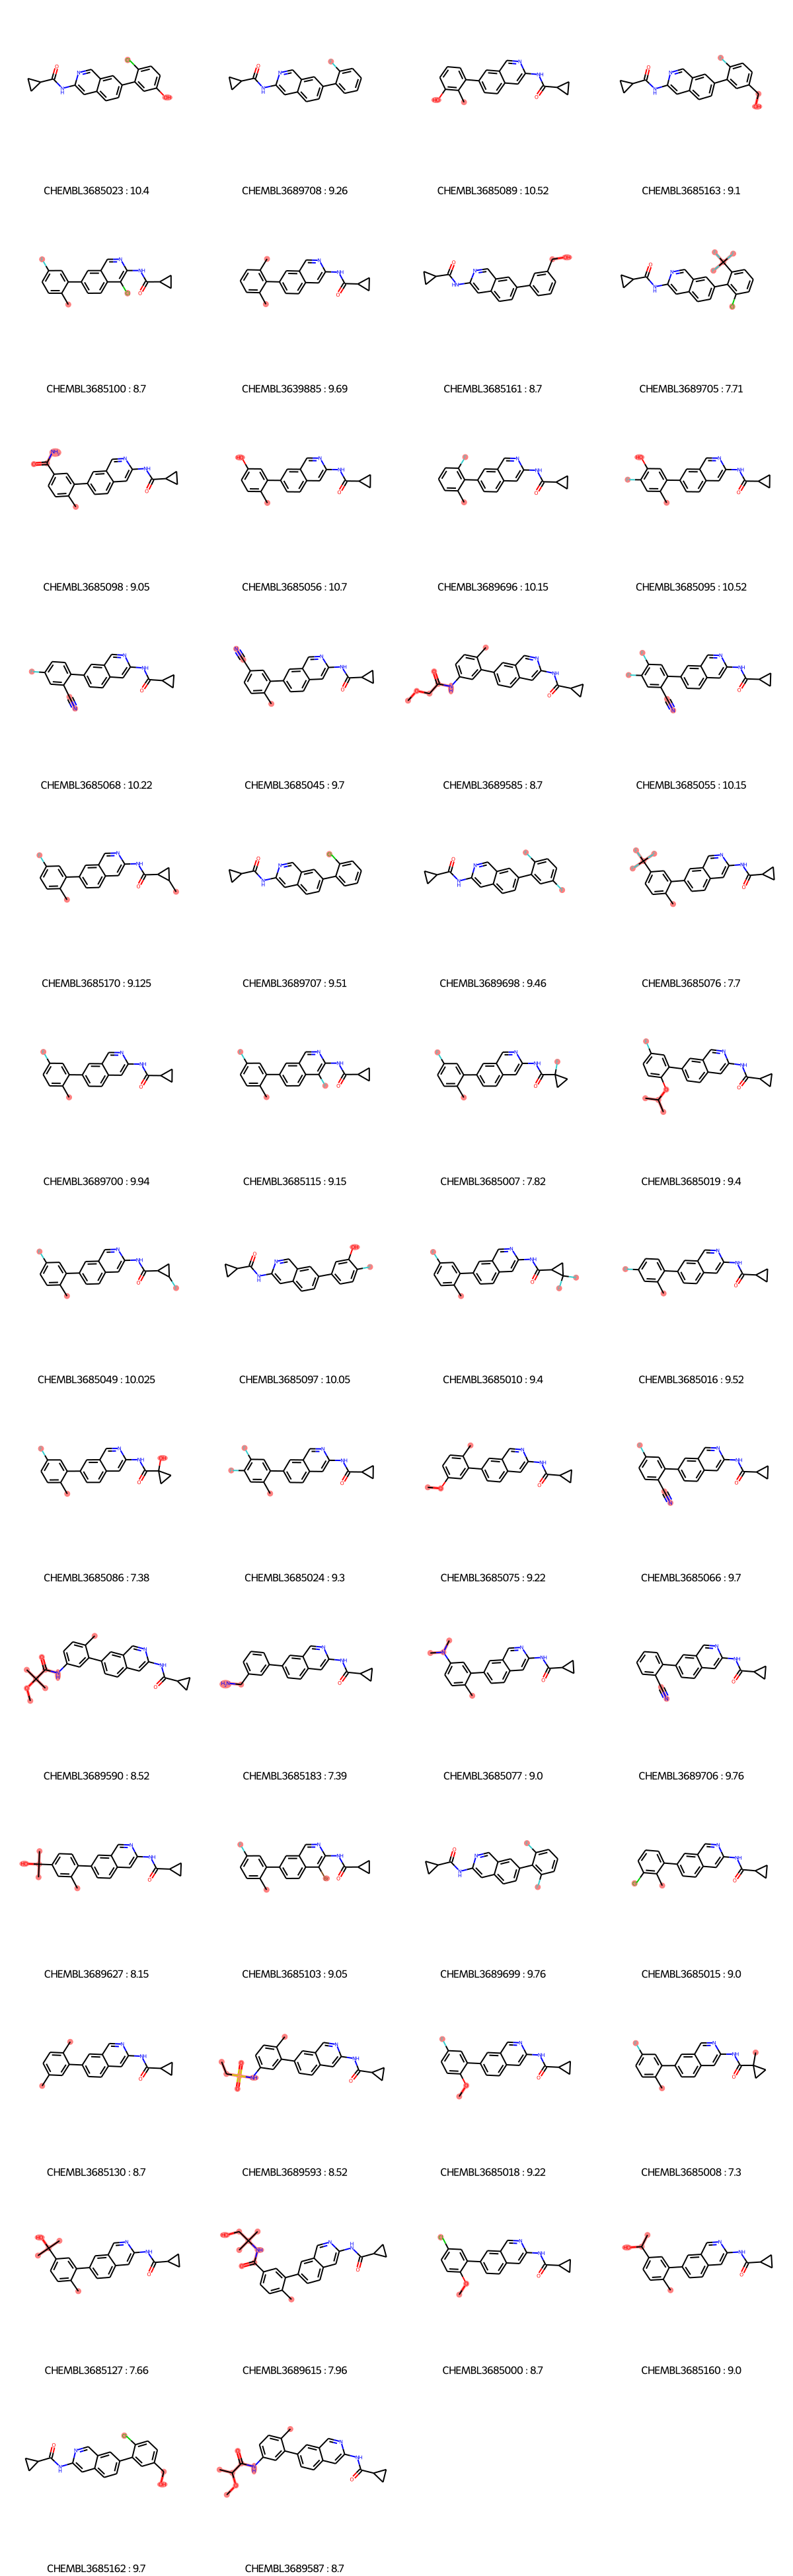

In [11]:
hl_atom_list = []
for each_mol in cur_scaf_df['ROMol']:
    highlight = get_atoms_to_highlight(mol_scaffold_of_interest, each_mol)
    each_mol.__sssAtoms = highlight
    hl_atom_list.append(highlight)

Draw.MolsToGridImage(cur_scaf_df['ROMol'].values, 
                     legends=custom_legend, 
                     highlightAtomLists = hl_atom_list, 
                     molsPerRow=4,
                     subImgSize=(300,300), 
                     useSVG=False)